In [10]:
# Sarah loves music

from carabao.neurotron import Pulse,Terminal,Synapses,toy
from carabao.util import repr
from carabao.screen import Screen
from numpy import array

#===========================================================================
# class Moni
#===========================================================================

class Moni:
    def __init__(self,m,n):
        self.screen = Screen('Neurons',m,n)
    def __call__(self,cell,i,j):
        u = cell.u.out()
        q = cell.q.out()
        p = cell.p.out()
        y = cell.y.out()
        d = cell.d.out()
        self.screen.neurotron((i,j),u,q,p,y,d)
    def xlabel(self,x,txt,size=None):
        self.screen.text(x,-0.75,txt)
    def title(self,txt,size=10):
        scr = self.screen
        x = (scr.n-1)/2;  y = scr.m + 0.3
        self.screen.text(x,y,txt,size=size)

#===================================================================================
# class: Core
#===================================================================================

class Core:
    """
    class Core: implements a Neurotron core functionality
    >>> core = Core(k,excite,predict,depress,(10,3))
    """
    def __init__(self,k, e,d,p, name=""):
        self.k = k
        self.name = name

        self.excite  = Terminal(e.w[k],e.theta,'excite')
        self.depress = Terminal(d.w[k],d.theta,'depress')
        self.predict = Terminal(p.W[k],p.theta,'predict')

    def __call__(self,f,c,V,log=None):
        e = self.excite.empower(f)
        u = self.excite.spike(e)
        if log is not None: 
            print("   ",log,self.name,"e:",repr(e), "u:",u)

        v = self.depress.empower(c)
        d = self.depress.spike(v) 
        if log is not None: 
            print("   ",log,self.name,"v:",repr(v), "d:",d)

        E = self.predict.empower(V)
        s = self.predict.spike(E)
        if log is not None: 
            print("   ",log,self.name,"E:",repr(E), "s:",repr(s))

    def __repr__(self):
        return "Core('%s',%g"% (self.name,self.k) + ")"
        
#===================================================================================
# class: Neurotron
#===================================================================================

class Neurotron:
    """
    class Neurotron: full functionality
    >>> par = toy('sarah')
    >>> cell0 = Neurotron(k:=0,par,(10,3),'cell0')
    >>> print(cell0)
    """
    def __init__(self,k,par,sizes,name=None):
        self.k = k
        self.sizes = sizes
        self.name = name

        self.u = Pulse(0,1)
        self.q = Pulse(2,1)
        self.p = Pulse(3,5)
        self.y = Pulse(1,1)
        self.d = Pulse(0,3)
        
        epar,dpar,ppar = par

        self.excite  = Terminal(epar.w[k],epar.theta,'excite')
        self.excite.synapses = Synapses(epar.k[k],epar.p[k],epar.eta)

        self.depress = Terminal(dpar.w[k],dpar.theta,'depress')
        self.depress.synapses = Synapses(dpar.g[k],dpar.p[k],dpar.eta)
    
        self.predict = Terminal(ppar.W[k],ppar.theta,'predict')
        self.predict.synapses = Synapses(ppar.K[k],ppar.P[k],ppar.eta)

    def __call__(self,y,log=None):
        def _or(x,y): return min(x+y,1)
        def _not(x): return (1-x)
            
        nc,nf = self.sizes; k = self.k
        c = y[:nc];  f = y[nc:nc+nf]
        
        if log is not None:
           print("\nf:",f,", c:",c)
            
        _u = self.excite(f,"=> excite-%g" % k)
        u = self.u(_u,' - u%g:' % k)
        q = self.q(_u,' - q%g:' % k)
  
        self.s = self.predict(c,"=> predict-%g" % k)
        p = self.p(0,' - p%g:' % k)

        _d = self.depress(c,"=> depress-%g" % k)
        d = self.d(_d*_not(p)*q,' - d%g:' % k)

        _y = _or(u*p,q*_not(d))
        print(" - y%g = %g*%g || %g*(not %g) =" % (k,u,p,q,d),_y) 
        y[k] = self.y(_y,' - y%g:' % k)

        if log is not None:
            print("y = [c,f]:",[y[:nc],y[nc:nc+nf]])
        return y

    def __repr__(self):
        #state = "), <updy> = <%g%g%g%g>" % (self.u,self.p,self.d,self.y)
        return "Neurotron('%s',%g"% (self.name,self.k) + ""

#===========================================================================
# class Cells
#===========================================================================

class Cells:
    def __init__(self,n,par,sizes):
        self.cells = []
        for k in range(n):
            cell = Neurotron(k,par,sizes)
            self.cells.append(cell)
        self.u = [[] for k in range(n)];  
        self.q = [[] for k in range(n)];  
        self.p = [[] for k in range(n)];  
        self.d = [[] for k in range(n)];  
        self.y = [[] for k in range(n)];  

    def __call__(self,y,log=None):
        if log is not None:
            print("\n"+log)
        for k in range(len(self.cells)):
            y = self.cells[k](y,log)

        for k in self.range():
            self.u[k].append(self[k].u.out())
            self.q[k].append(self[k].q.out())
            self.p[k].append(self[k].p.out())
            self.d[k].append(self[k].d.out())
            self.y[k].append(self[k].y.out())
        self.log(log)
        return y

    def __getitem__(self,k):
        return self.cells[k]

    def range(self):
        return range(len(self.cells))
        
    def plot(self,j,tag=''):   # plot cell column at monitor location (*,j)
        for k in range(len(self.cells)):
            mon(self.cells[k],k,j)
        mon.xlabel(j,tag)

    def log(self,tag=None):
        print('\nsummary',tag)
        print("   u:",self.u)
        print("   q:",self.q)
        print("   p:",self.p)
        print("   d:",self.d)
        print("   y:",self.y)
        
#=========================================================================
# helper: concatenate two Neurotron output lists
#=========================================================================

def cat(c,f):
    """
    cat(): concatenate two Neurotron output lists, return also sizes
    >>> y,sizes = cat(c,f)
    """
    sizes = (len(c),len(f))
    return (c+f,sizes)




iteration 0 (excite)

f: [1, 1, 0, 1, 1, 1, 0, 1, 0, 1] , c: [0, 0, 0]
=> excite-0 [1 1 0 1 1 1 0 1 0 1] -> #[1 1 0 1 1 1 0 1 0 1] -> #[1 1 0 1 1 1 0 1 0 1] -> :[1]
 - u0:  1 -> ([1],1/1) -> 1
 - q0:  1 -> ([1,0,0],0/1) -> 0
=> predict-0 [0 0 0] -> #[1 0 0; 1 0 0] -> #[0 0 0; 0 0 0] -> :[0 0]
 - p0:  0 -> ([0,0,0,0],0/5) -> 0
=> depress-0 [0 0 0] -> #[1 1 1] -> #[0 0 0] -> :[0]
 - d0:  0 -> ([0],0/3) -> 0
 - y0 = 1*0 || 0*(not 0) = 0
 - y0:  0 -> ([0,0],0/1) -> 0
y = [c,f]: [[0, 0, 0], [1, 1, 0, 1, 1, 1, 0, 1, 0, 1]]

f: [1, 1, 0, 1, 1, 1, 0, 1, 0, 1] , c: [0, 0, 0]
=> excite-1 [1 1 0 1 1 1 0 1 0 1] -> #[1 1 0 1 1 1 0 1 0 1] -> #[1 1 0 1 1 1 0 1 0 1] -> :[1]
 - u1:  1 -> ([1],1/1) -> 1
 - q1:  1 -> ([1,0,0],0/1) -> 0
=> predict-1 [0 0 0] -> #[1 0 0; 1 0 0] -> #[0 0 0; 0 0 0] -> :[0 0]
 - p1:  0 -> ([0,0,0,0],0/5) -> 0
=> depress-1 [0 0 0] -> #[1 1 1] -> #[0 0 0] -> :[0]
 - d1:  0 -> ([0],0/3) -> 0
 - y1 = 1*0 || 0*(not 0) = 0
 - y1:  0 -> ([0,0],0/1) -> 0
y = [c,f]: [[0, 0, 0], [1, 1,

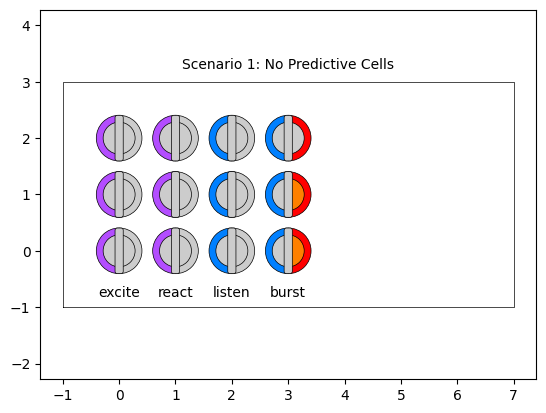

In [11]:
#===========================================================================
# Secario 1: No predictive cells 
#===========================================================================
par,token = toy('sarah')
par[0].p[2] = par[0].p[1] = par[0].p[0] # overwrite => all the same

y,sizes = cat(c:=[0,0,0],token['Sarah'])
cells = Cells(3,par,sizes)

mon = Moni(3,7);  mon.title('Scenario 1: No Predictive Cells')

y = cells(y,'iteration 0 (excite)');   cells.plot(0,'excite')
y = cells(y,'iteration 1 (react)');    cells.plot(1,'react')
y = cells(y,'iteration 2 (listen)');   cells.plot(2,'listen')
y = cells(y,'iteration 3 (burst)');    cells.plot(3,'burst')


iteration 0 (excite)

f: [1, 1, 0, 1, 1, 1, 0, 1, 0, 1] , c: [0, 0, 0]
=> excite-0 [1 1 0 1 1 1 0 1 0 1] -> #[1 1 0 1 1 1 0 1 0 1] -> #[1 1 0 1 1 1 0 1 0 1] -> :[1]
 - u0:  1 -> ([1],1/1) -> 1
 - q0:  1 -> ([1,0,0],0/1) -> 0
=> predict-0 [0 0 0] -> #[1 0 0; 1 0 0] -> #[0 0 0; 0 0 0] -> :[0 0]
 - p0:  0 -> ([0,0,0,0],4/5) -> 1
=> depress-0 [0 0 0] -> #[1 1 1] -> #[0 0 0] -> :[0]
 - d0:  0 -> ([0],0/3) -> 0
 - y0 = 1*1 || 0*(not 0) = 1
 - y0:  1 -> ([1,0],0/1) -> 0
y = [c,f]: [[0, 0, 0], [1, 1, 0, 1, 1, 1, 0, 1, 0, 1]]

f: [1, 1, 0, 1, 1, 1, 0, 1, 0, 1] , c: [0, 0, 0]
=> excite-1 [1 1 0 1 1 1 0 1 0 1] -> #[1 1 0 1 1 1 0 1 0 1] -> #[1 1 0 1 1 1 0 1 0 1] -> :[1]
 - u1:  1 -> ([1],1/1) -> 1
 - q1:  1 -> ([1,0,0],0/1) -> 0
=> predict-1 [0 0 0] -> #[1 0 0; 1 0 0] -> #[0 0 0; 0 0 0] -> :[0 0]
 - p1:  0 -> ([0,0,0,0],0/5) -> 0
=> depress-1 [0 0 0] -> #[1 1 1] -> #[0 0 0] -> :[0]
 - d1:  0 -> ([0],0/3) -> 0
 - y1 = 1*0 || 0*(not 0) = 0
 - y1:  0 -> ([0,0],0/1) -> 0
y = [c,f]: [[0, 0, 0], [1, 1,

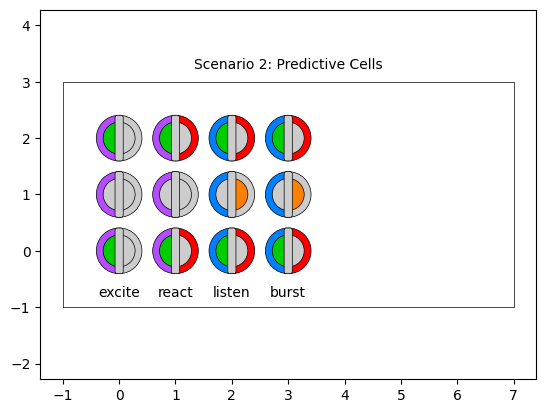

In [12]:
#===========================================================================
# Secario 2: some predictive cells 
#===========================================================================
par,token = toy('sarah')
par[0].p[2] = par[0].p[1] = par[0].p[0] # overwrie => all the same

y,sizes = cat(c:=[0,0,0],token['Sarah'])
cells = Cells(3,par,sizes)
cells[0].p.set(1)
cells[2].p.set(1)

mon = Moni(3,7);  mon.title('Scenario 2: Predictive Cells')

y = cells(y,'iteration 0 (excite)');   cells.plot(0,'excite')
y = cells(y,'iteration 1 (react)');    cells.plot(1,'react')
y = cells(y,'iteration 2 (listen)');   cells.plot(2,'listen')
y = cells(y,'iteration 3 (burst)');    cells.plot(3,'burst')